<a href="https://colab.research.google.com/github/duttaprat/BMI_503/blob/main/class_1/public_database.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Class 1 - Notebook 0: Accessing Omics Data and Reference Genomes

**Course**: BMI 503 - Introduction to Computer Science for Biomedical Informatics  
**Instructor**: Pratik Dutta  
**Term**: Fall 2025  
**Institution**: Stony Brook University

---

## Learning Objectives
1. Access human reference genome sequences
2. Download genomics data from NCBI
3. Access RNA-seq data from GEO
4. Download single-cell data
5. Access imaging data from public repositories

---

## Introduction: Where to Get Omics Data?

### Major Public Databases

**Genomics:**
- 🧬 **NCBI**: GenBank, RefSeq, dbSNP, ClinVar
- 🧬 **Ensembl**: Genome annotations, variation data
- 🧬 **UCSC Genome Browser**: Reference genomes, tracks

**Transcriptomics:**
- 📊 **GEO (Gene Expression Omnibus)**: Microarray, RNA-seq
- 📊 **SRA (Sequence Read Archive)**: Raw sequencing data
- 📊 **GTEx**: Tissue-specific expression
- 📊 **TCGA**: Cancer genomics

**Imagomics:**
- 🔬 **TCGA**: Whole slide images
- 🔬 **Human Protein Atlas**: Tissue/cell images
- 🔬 **IDC (Imaging Data Commons)**: Cancer imaging

---

## Setup

In [1]:
# Install required packages
!pip install biopython requests pandas geoparse scanpy wget -q
print("✅ Packages installed!")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.7/170.7 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 103.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.0/80.0 kB 7.6 MB/s eta 0:00:00
✅ Packages installed!


In [3]:
import warnings
warnings.filterwarnings('ignore')

from Bio import Entrez, SeqIO
import requests
import pandas as pd
import gzip
import os

# Set your email for NCBI (REQUIRED!)
Entrez.email = "pratik.dutta@stonybrook.edu"  # CHANGE THIS!

print("📦 Libraries loaded!")
print("\n⚠️ IMPORTANT: Set your email in Entrez.email above!")

📦 Libraries loaded!

⚠️ IMPORTANT: Set your email in Entrez.email above!


---

# Part 1: Human Reference Genome

## What is a Reference Genome?

A **reference genome** is a representative DNA sequence used as a standard for comparison.

### Human Reference Versions:
- **GRCh38/hg38**: Current version (2013, updated)
- **GRCh37/hg19**: Previous version (2009)

### Why We Need It:
- Align sequencing reads
- Identify variants
- Annotate genes
- Compare across studies

---

## 1.1: Download Chromosome Sequence from NCBI

In [4]:
def download_chromosome_ncbi(chrom, start=None, end=None):
    """
    Download human chromosome sequence from NCBI.

    Parameters:
    - chrom: chromosome number (1-22, X, Y, MT)
    - start: start position (optional, for partial sequence)
    - end: end position (optional, for partial sequence)

    Returns:
    - SeqRecord object
    """
    # Chromosome accession numbers (GRCh38)
    chrom_accessions = {
        '1': 'NC_000001.11', '2': 'NC_000002.12', '3': 'NC_000003.12',
        '4': 'NC_000004.12', '5': 'NC_000005.10', '6': 'NC_000006.12',
        '7': 'NC_000007.14', '8': 'NC_000008.11', '9': 'NC_000009.12',
        '10': 'NC_000010.11', '11': 'NC_000011.10', '12': 'NC_000012.12',
        '13': 'NC_000013.11', '14': 'NC_000014.9', '15': 'NC_000015.10',
        '16': 'NC_000016.10', '17': 'NC_000017.11', '18': 'NC_000018.10',
        '19': 'NC_000019.10', '20': 'NC_000020.11', '21': 'NC_000021.9',
        '22': 'NC_000022.11', 'X': 'NC_000023.11', 'Y': 'NC_000024.10',
        'MT': 'NC_012920.1'
    }

    accession = chrom_accessions.get(str(chrom))
    if not accession:
        raise ValueError(f"Invalid chromosome: {chrom}")

    print(f"📥 Downloading chromosome {chrom} ({accession})...")

    # Fetch sequence
    if start and end:
        # Fetch partial sequence
        handle = Entrez.efetch(
            db="nucleotide",
            id=accession,
            rettype="fasta",
            retmode="text",
            seq_start=start,
            seq_stop=end
        )
        print(f"   Region: {start:,} - {end:,} ({end-start:,} bp)")
    else:
        # Fetch full chromosome
        handle = Entrez.efetch(
            db="nucleotide",
            id=accession,
            rettype="fasta",
            retmode="text"
        )
        print(f"   Fetching full chromosome...")

    record = SeqIO.read(handle, "fasta")
    handle.close()

    print(f"✅ Downloaded {len(record.seq):,} bp")
    return record

# Example: Download a small region of chromosome 1
# BRCA2 gene region on chr13
chr13_region = download_chromosome_ncbi('13', start=32300000, end=32400000)

print(f"\n📊 Sequence info:")
print(f"  ID: {chr13_region.id}")
print(f"  Length: {len(chr13_region.seq):,} bp")
print(f"  First 100 bp: {chr13_region.seq[:100]}")

📥 Downloading chromosome 13 (NC_000013.11)...
   Region: 32,300,000 - 32,400,000 (100,000 bp)
✅ Downloaded 100,001 bp

📊 Sequence info:
  ID: NC_000013.11:32300000-32400000
  Length: 100,001 bp
  First 100 bp: AGTTGTTTTTCCACGTAGGCTGTTGGTGTAGTAATTCTACCCAAATCTGTCATTGATCTTTTTGTAACTTTGTTTCCTATTTGAGGTCACAGTGAGTGAG


## 1.2: Get Gene Sequence by Name

In [5]:
def get_gene_sequence(gene_name):
    """
    Search for a gene and download its sequence from NCBI.

    Parameters:
    - gene_name: Gene symbol (e.g., 'BRCA1', 'TP53')

    Returns:
    - SeqRecord object
    """
    print(f"🔍 Searching for gene: {gene_name}")

    # Search for the gene
    search_term = f"{gene_name}[Gene Name] AND Homo sapiens[Organism] AND RefSeq[Filter]"
    handle = Entrez.esearch(db="nucleotide", term=search_term, retmax=5)
    record = Entrez.read(handle)
    handle.close()

    if not record['IdList']:
        print(f"❌ No results found for {gene_name}")
        return None

    # Get the first result
    gene_id = record['IdList'][0]
    print(f"✅ Found ID: {gene_id}")

    # Fetch sequence
    handle = Entrez.efetch(db="nucleotide", id=gene_id, rettype="fasta", retmode="text")
    seq_record = SeqIO.read(handle, "fasta")
    handle.close()

    print(f"📥 Downloaded {len(seq_record.seq):,} bp")
    return seq_record

# Example: Get TP53 gene sequence
tp53 = get_gene_sequence('TP53')

if tp53:
    print(f"\n📊 TP53 Gene:")
    print(f"  ID: {tp53.id}")
    print(f"  Description: {tp53.description}")
    print(f"  Length: {len(tp53.seq):,} bp")
    print(f"  First 100 bp: {tp53.seq[:100]}")

    # Calculate GC content
    gc_count = tp53.seq.count('G') + tp53.seq.count('C')
    gc_percent = (gc_count / len(tp53.seq)) * 100
    print(f"  GC content: {gc_percent:.2f}%")

🔍 Searching for gene: TP53
✅ Found ID: 383209646
📥 Downloaded 32,772 bp

📊 TP53 Gene:
  ID: NG_017013.2
  Description: NG_017013.2 Homo sapiens tumor protein p53 (TP53), RefSeqGene (LRG_321) on chromosome 17
  Length: 32,772 bp
  First 100 bp: CTCCTTGGTTCAAGTAATTCTCCTGCCTCAGACTCCAGAGTAGCTGGGATTACAGGCGCCCGCCACCACGCCCAGCTAATTTTTTGTATTTTTAATAGAG
  GC content: 48.96%


## 1.3: Download Reference Genome from Ensembl

In [6]:
def download_ensembl_chromosome(chrom, output_file="chr.fa.gz"):
    """
    Download chromosome FASTA from Ensembl FTP.

    Parameters:
    - chrom: chromosome number (1-22, X, Y, MT)
    - output_file: output filename
    """
    # Ensembl FTP URL (GRCh38)
    base_url = "https://ftp.ensembl.org/pub/release-110/fasta/homo_sapiens/dna/"

    if chrom == 'MT':
        filename = "Homo_sapiens.GRCh38.dna.chromosome.MT.fa.gz"
    else:
        filename = f"Homo_sapiens.GRCh38.dna.chromosome.{chrom}.fa.gz"

    url = base_url + filename

    print(f"📥 Downloading chromosome {chrom} from Ensembl...")
    print(f"   URL: {url}")
    print(f"   ⚠️ Warning: This can be large (50-250 MB per chromosome)")

    # Check if file exists
    if os.path.exists(output_file):
        print(f"   ✅ File already exists: {output_file}")
        return output_file

    # Download
    response = requests.get(url, stream=True)

    if response.status_code == 200:
        with open(output_file, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"✅ Downloaded to {output_file}")
        return output_file
    else:
        print(f"❌ Download failed: {response.status_code}")
        return None

# Example: Download mitochondrial genome (small, ~16kb)
print("💡 Downloading mitochondrial genome (small example)...\n")
mt_file = download_ensembl_chromosome('MT', output_file='chr_MT.fa.gz')

if mt_file:
    # Read the gzipped FASTA
    with gzip.open(mt_file, 'rt') as f:
        mt_seq = SeqIO.read(f, 'fasta')

    print(f"\n📊 Mitochondrial Genome:")
    print(f"  ID: {mt_seq.id}")
    print(f"  Length: {len(mt_seq.seq):,} bp")
    print(f"  First 100 bp: {mt_seq.seq[:100]}")

💡 Downloading mitochondrial genome (small example)...

📥 Downloading chromosome MT from Ensembl...
   URL: https://ftp.ensembl.org/pub/release-110/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.chromosome.MT.fa.gz
   ⚠️ Warning: This can be large (50-250 MB per chromosome)
✅ Downloaded to chr_MT.fa.gz

📊 Mitochondrial Genome:
  ID: MT
  Length: 16,569 bp
  First 100 bp: GATCACAGGTCTATCACCCTATTAACCACTCACGGGAGCTCTCCATGCATTTGGTATTTTCGTCTGGGGGGTATGCACGCGATAGCATTGCGAGACGCTG


---

# Part 2: Genomics Data from Public Databases

## 2.1: Search and Download from NCBI

In [7]:
def search_ncbi_variants(gene_name, max_results=10):
    """
    Search for variants in a gene from dbSNP.

    Parameters:
    - gene_name: Gene symbol
    - max_results: Maximum number of results

    Returns:
    - List of variant IDs
    """
    print(f"🔍 Searching variants in {gene_name}...")

    search_term = f"{gene_name}[Gene Name] AND human[Organism]"
    handle = Entrez.esearch(db="snp", term=search_term, retmax=max_results)
    record = Entrez.read(handle)
    handle.close()

    variant_ids = record['IdList']
    print(f"✅ Found {len(variant_ids)} variants")

    return variant_ids

def get_variant_info(rs_id):
    """
    Get detailed information about a variant.

    Parameters:
    - rs_id: dbSNP rs ID
    """
    handle = Entrez.efetch(db="snp", id=rs_id, rettype="xml", retmode="xml")
    records = Entrez.read(handle)
    handle.close()

    return records

# Example: Search for BRCA1 variants
brca1_variants = search_ncbi_variants('BRCA1', max_results=5)

print(f"\n📋 First 5 BRCA1 variant IDs:")
for i, var_id in enumerate(brca1_variants, 1):
    print(f"  {i}. rs{var_id}")

🔍 Searching variants in BRCA1...
✅ Found 5 variants

📋 First 5 BRCA1 variant IDs:
  1. rs2552282559
  2. rs2552281972
  3. rs2552281880
  4. rs2552281808
  5. rs2552281780


---

# Part 3: Transcriptomics Data from GEO

## 3.1: Search GEO Database

In [8]:
def search_geo(query, max_results=10):
    """
    Search GEO database.

    Parameters:
    - query: Search term
    - max_results: Maximum results

    Returns:
    - List of GEO accession numbers
    """
    print(f"🔍 Searching GEO for: {query}")

    handle = Entrez.esearch(
        db="gds",
        term=query,
        retmax=max_results
    )
    record = Entrez.read(handle)
    handle.close()

    print(f"✅ Found {record['Count']} datasets")

    # Get details
    if record['IdList']:
        handle = Entrez.esummary(db="gds", id=",".join(record['IdList']))
        summaries = Entrez.read(handle)
        handle.close()
        return summaries

    return []

# Example: Search for breast cancer RNA-seq data
results = search_geo('breast cancer RNA-seq', max_results=5)

print(f"\n📊 Top 5 Breast Cancer RNA-seq Datasets:\n")
for i, dataset in enumerate(results, 1):
    print(f"{i}. {dataset['Accession']}")
    print(f"   Title: {dataset['title']}")
    print(f"   Type: {dataset['entryType']}")
    print(f"   Samples: {dataset['n_samples']}")
    print()

🔍 Searching GEO for: breast cancer RNA-seq
✅ Found 6193 datasets

📊 Top 5 Breast Cancer RNA-seq Datasets:

1. GSE281194
   Title: RNA seq of breast cancer cells treated with different concentration gradients of Thapsigargin (TG), Tunicamycin (TM), and FCCP.
   Type: GSE
   Samples: IntegerElement(44, attributes={})

2. GSE280446
   Title: Transcriptional alteration in the treatment of MDA-MB-231 cells using SFN and/or ZA
   Type: GSE
   Samples: IntegerElement(12, attributes={})

3. GSE246319
   Title: EGR1 induction compromises the therapeutic efficacy of BET depletion in triple-negative breast cancer (RNA-Seq)
   Type: GSE
   Samples: IntegerElement(9, attributes={})

4. GSE306386
   Title: BRMS1L promotes chemotherapy sensitivity by inhibiting autophagy in breast cancer
   Type: GSE
   Samples: IntegerElement(2, attributes={})

5. GSE233414
   Title: Systematic Pan-cancer Functional Inference and Validation of Hyper, Hypo and Neomorphic Mutations
   Type: GSE
   Samples: IntegerElem

## 3.2: Download GEO Dataset with GEOparse

In [9]:
import GEOparse

def download_geo_series(geo_id):
    """
    Download and parse GEO Series.

    Parameters:
    - geo_id: GEO Series ID (e.g., 'GSE48968')

    Returns:
    - GEO object
    """
    print(f"📥 Downloading {geo_id}...")

    gse = GEOparse.get_GEO(geo=geo_id, destdir="./")

    print(f"✅ Downloaded!")
    print(f"\n📊 Dataset Info:")
    print(f"  Title: {gse.metadata['title'][0]}")
    print(f"  Organism: {gse.metadata['organism'][0] if 'organism' in gse.metadata else 'N/A'}")
    print(f"  Samples: {len(gse.gsms)}")
    print(f"  Platforms: {len(gse.gpls)}")

    return gse

# Example: Small public dataset
print("💡 Downloading a small example dataset...\n")
try:
    gse = download_geo_series('GSE48968')  # Small RNA-seq dataset

    # Show sample info
    print(f"\n📋 First 3 samples:")
    for i, (sample_name, sample) in enumerate(list(gse.gsms.items())[:3], 1):
        print(f"  {i}. {sample_name}")
        print(f"     Title: {sample.metadata['title'][0]}")
        print(f"     Type: {sample.metadata['type'][0] if 'type' in sample.metadata else 'N/A'}")

except Exception as e:
    print(f"⚠️ Error downloading: {e}")
    print("💡 This requires internet connection")

03-Nov-2025 14:40:49 DEBUG utils - Directory ./ already exists. Skipping.
DEBUG:GEOparse:Directory ./ already exists. Skipping.
03-Nov-2025 14:40:49 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE48nnn/GSE48968/soft/GSE48968_family.soft.gz to ./GSE48968_family.soft.gz
INFO:GEOparse:Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE48nnn/GSE48968/soft/GSE48968_family.soft.gz to ./GSE48968_family.soft.gz


💡 Downloading a small example dataset...

📥 Downloading GSE48968...


100%|██████████| 101k/101k [00:00<00:00, 196kB/s] 
03-Nov-2025 14:40:50 DEBUG downloader - Size validation passed
DEBUG:GEOparse:Size validation passed
03-Nov-2025 14:40:50 DEBUG downloader - Moving /tmp/tmpq_wiwbr1 to /content/GSE48968_family.soft.gz
DEBUG:GEOparse:Moving /tmp/tmpq_wiwbr1 to /content/GSE48968_family.soft.gz
03-Nov-2025 14:40:50 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE48nnn/GSE48968/soft/GSE48968_family.soft.gz
DEBUG:GEOparse:Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE48nnn/GSE48968/soft/GSE48968_family.soft.gz
03-Nov-2025 14:40:50 INFO GEOparse - Parsing ./GSE48968_family.soft.gz: 
INFO:GEOparse:Parsing ./GSE48968_family.soft.gz: 
03-Nov-2025 14:40:50 DEBUG GEOparse - DATABASE: GeoMiame
DEBUG:GEOparse:DATABASE: GeoMiame
03-Nov-2025 14:40:50 DEBUG GEOparse - SERIES: GSE48968
DEBUG:GEOparse:SERIES: GSE48968
03-Nov-2025 14:40:50 DEBUG GEOparse - PLATFORM: GPL13112
DEBUG:GEOparse:PLATFORM: GPL13112
03-Nov-2

✅ Downloaded!

📊 Dataset Info:
  Title: Single-cell RNA-seq reveals dynamic paracrine control of cellular variation
  Organism: N/A
  Samples: 2425
  Platforms: 2

📋 First 3 samples:
  1. GSM1189042
     Title: On_Chip_Stimulation_LPS_4h_S1
     Type: SRA
  2. GSM1189043
     Title: On_Chip_Stimulation_LPS_4h_S2
     Type: SRA
  3. GSM1189044
     Title: On_Chip_Stimulation_LPS_4h_S3
     Type: SRA


---

# Part 4: Single-Cell Data

## 4.1: Download Public scRNA-seq Datasets

In [11]:
import scanpy as sc

# Scanpy has built-in datasets
print("📦 Scanpy Built-in Datasets:\n")

datasets = [
    ('pbmc3k', '2,700 PBMCs from 10x Genomics'),
    ('pbmc68k_reduced', '68k PBMCs (reduced)'),
    ('paul15', 'Mouse hematopoiesis'),
    ('burczynski06', 'Colon cancer microarray'),
]

for name, desc in datasets:
    print(f"  • {name}: {desc}")

# Download PBMC dataset
print(f"\n📥 Downloading PBMC3k dataset...")
adata = sc.datasets.pbmc3k()

print(f"✅ Downloaded!")
print(f"\n📊 Dataset Info:")
print(f"  Cells: {adata.n_obs:,}")
print(f"  Genes: {adata.n_vars:,}")
print(f"  Data type: {type(adata.X)}")
print(f"\n📋 Cell metadata columns:")
print(f"  {list(adata.obs.columns)}")
print(f"\n📋 Gene metadata columns:")
print(f"  {list(adata.var.columns)}")

📦 Scanpy Built-in Datasets:

  • pbmc3k: 2,700 PBMCs from 10x Genomics
  • pbmc68k_reduced: 68k PBMCs (reduced)
  • paul15: Mouse hematopoiesis
  • burczynski06: Colon cancer microarray

📥 Downloading PBMC3k dataset...
✅ Downloaded!

📊 Dataset Info:
  Cells: 2,700
  Genes: 32,738
  Data type: <class 'scipy.sparse._csr.csr_matrix'>

📋 Cell metadata columns:
  []

📋 Gene metadata columns:
  ['gene_ids']


## 4.2: Download from 10x Genomics

In [15]:
def download_10x_dataset(dataset_name, output_dir="./data"):
    """
    Download public 10x Genomics datasets.

    Parameters:
    - dataset_name: Dataset identifier
    - output_dir: Output directory
    """
    # Some public 10x datasets
    datasets = {
        'pbmc_1k_v3': 'https://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_1k_v3/pbmc_1k_v3_filtered_feature_bc_matrix.h5',
        'heart_1k_v3': 'https://cf.10xgenomics.com/samples/cell-exp/3.0.0/heart_1k_v3/heart_1k_v3_filtered_feature_bc_matrix.h5',
    }

    if dataset_name not in datasets:
        print(f"❌ Dataset {dataset_name} not available")
        print(f"Available datasets: {list(datasets.keys())}")
        return None

    url = datasets[dataset_name]
    filename = url.split('/')[-1]
    filepath = os.path.join(output_dir, filename)

    # Create directory
    os.makedirs(output_dir, exist_ok=True)

    if os.path.exists(filepath):
        print(f"✅ File already exists: {filepath}")
        return filepath

    print(f"📥 Downloading {dataset_name}...")
    print(f"   URL: {url}")
    print(f"   ⚠️ This may take a few minutes...")

    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))

    with open(filepath, 'wb') as f:
        downloaded = 0
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
            downloaded += len(chunk)
            if total_size > 0:
                percent = (downloaded / total_size) * 100
                print(f"\r   Progress: {percent:.1f}%", end='')

    print(f"\n✅ Downloaded to {filepath}")
    return filepath

# List available datasets
print("📚 Available 10x Genomics Datasets:")
print("  1. pbmc_1k_v3: 1k PBMCs")
print("  2. heart_1k_v3: 1k Heart cells")
print("\n💡 Uncomment below to download (files are ~15-25 MB)")

# Uncomment to download:
h5_file = download_10x_dataset('pbmc_1k_v3')
if h5_file:
    adata = sc.read_10x_h5(h5_file)
    print(f"\n📊 Loaded: {adata.n_obs} cells × {adata.n_vars} genes")

📚 Available 10x Genomics Datasets:
  1. pbmc_1k_v3: 1k PBMCs
  2. heart_1k_v3: 1k Heart cells

💡 Uncomment below to download (files are ~15-25 MB)
📥 Downloading pbmc_1k_v3...
   URL: https://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_1k_v3/pbmc_1k_v3_filtered_feature_bc_matrix.h5
   ⚠️ This may take a few minutes...
   Progress: 100.0%
✅ Downloaded to ./data/pbmc_1k_v3_filtered_feature_bc_matrix.h5

📊 Loaded: 1222 cells × 33538 genes


In [16]:
adata

AnnData object with n_obs × n_vars = 1222 × 33538
    var: 'gene_ids', 'feature_types', 'genome'

📊 Dataset: 1176 cells × 15246 genes

🔍 Raw Expression Matrix:
   Shape: (1176, 15246)
   Type: <class 'numpy.ndarray'>
   Data:

[[-0.07017333 -0.24339919 -0.17419478 ... -0.10872265 -0.14475976
  -0.08992629]
 [-0.07017333 -0.24339919 -0.17419478 ... -0.10872265 -0.14475976
  -0.08992629]
 [-0.07017333 -0.24339919 -0.17419478 ... -0.10872265 -0.14475976
  -0.08992629]
 ...
 [-0.07017333 -0.24339919  6.67613111 ... -0.10872265 -0.14475976
  -0.08992629]
 [-0.07017333 -0.24339919 -0.17419478 ... -0.10872265 -0.14475976
  -0.08992629]
 [-0.07017333 -0.24339919 -0.17419478 ... -0.10872265 -0.14475976
  -0.08992629]]

   Min: -10.0
   Max: 10.0
   Mean: -0.00
   Non-zero values: 17,929,296 / 17,929,296

📊 Creating heatmap visualizations...



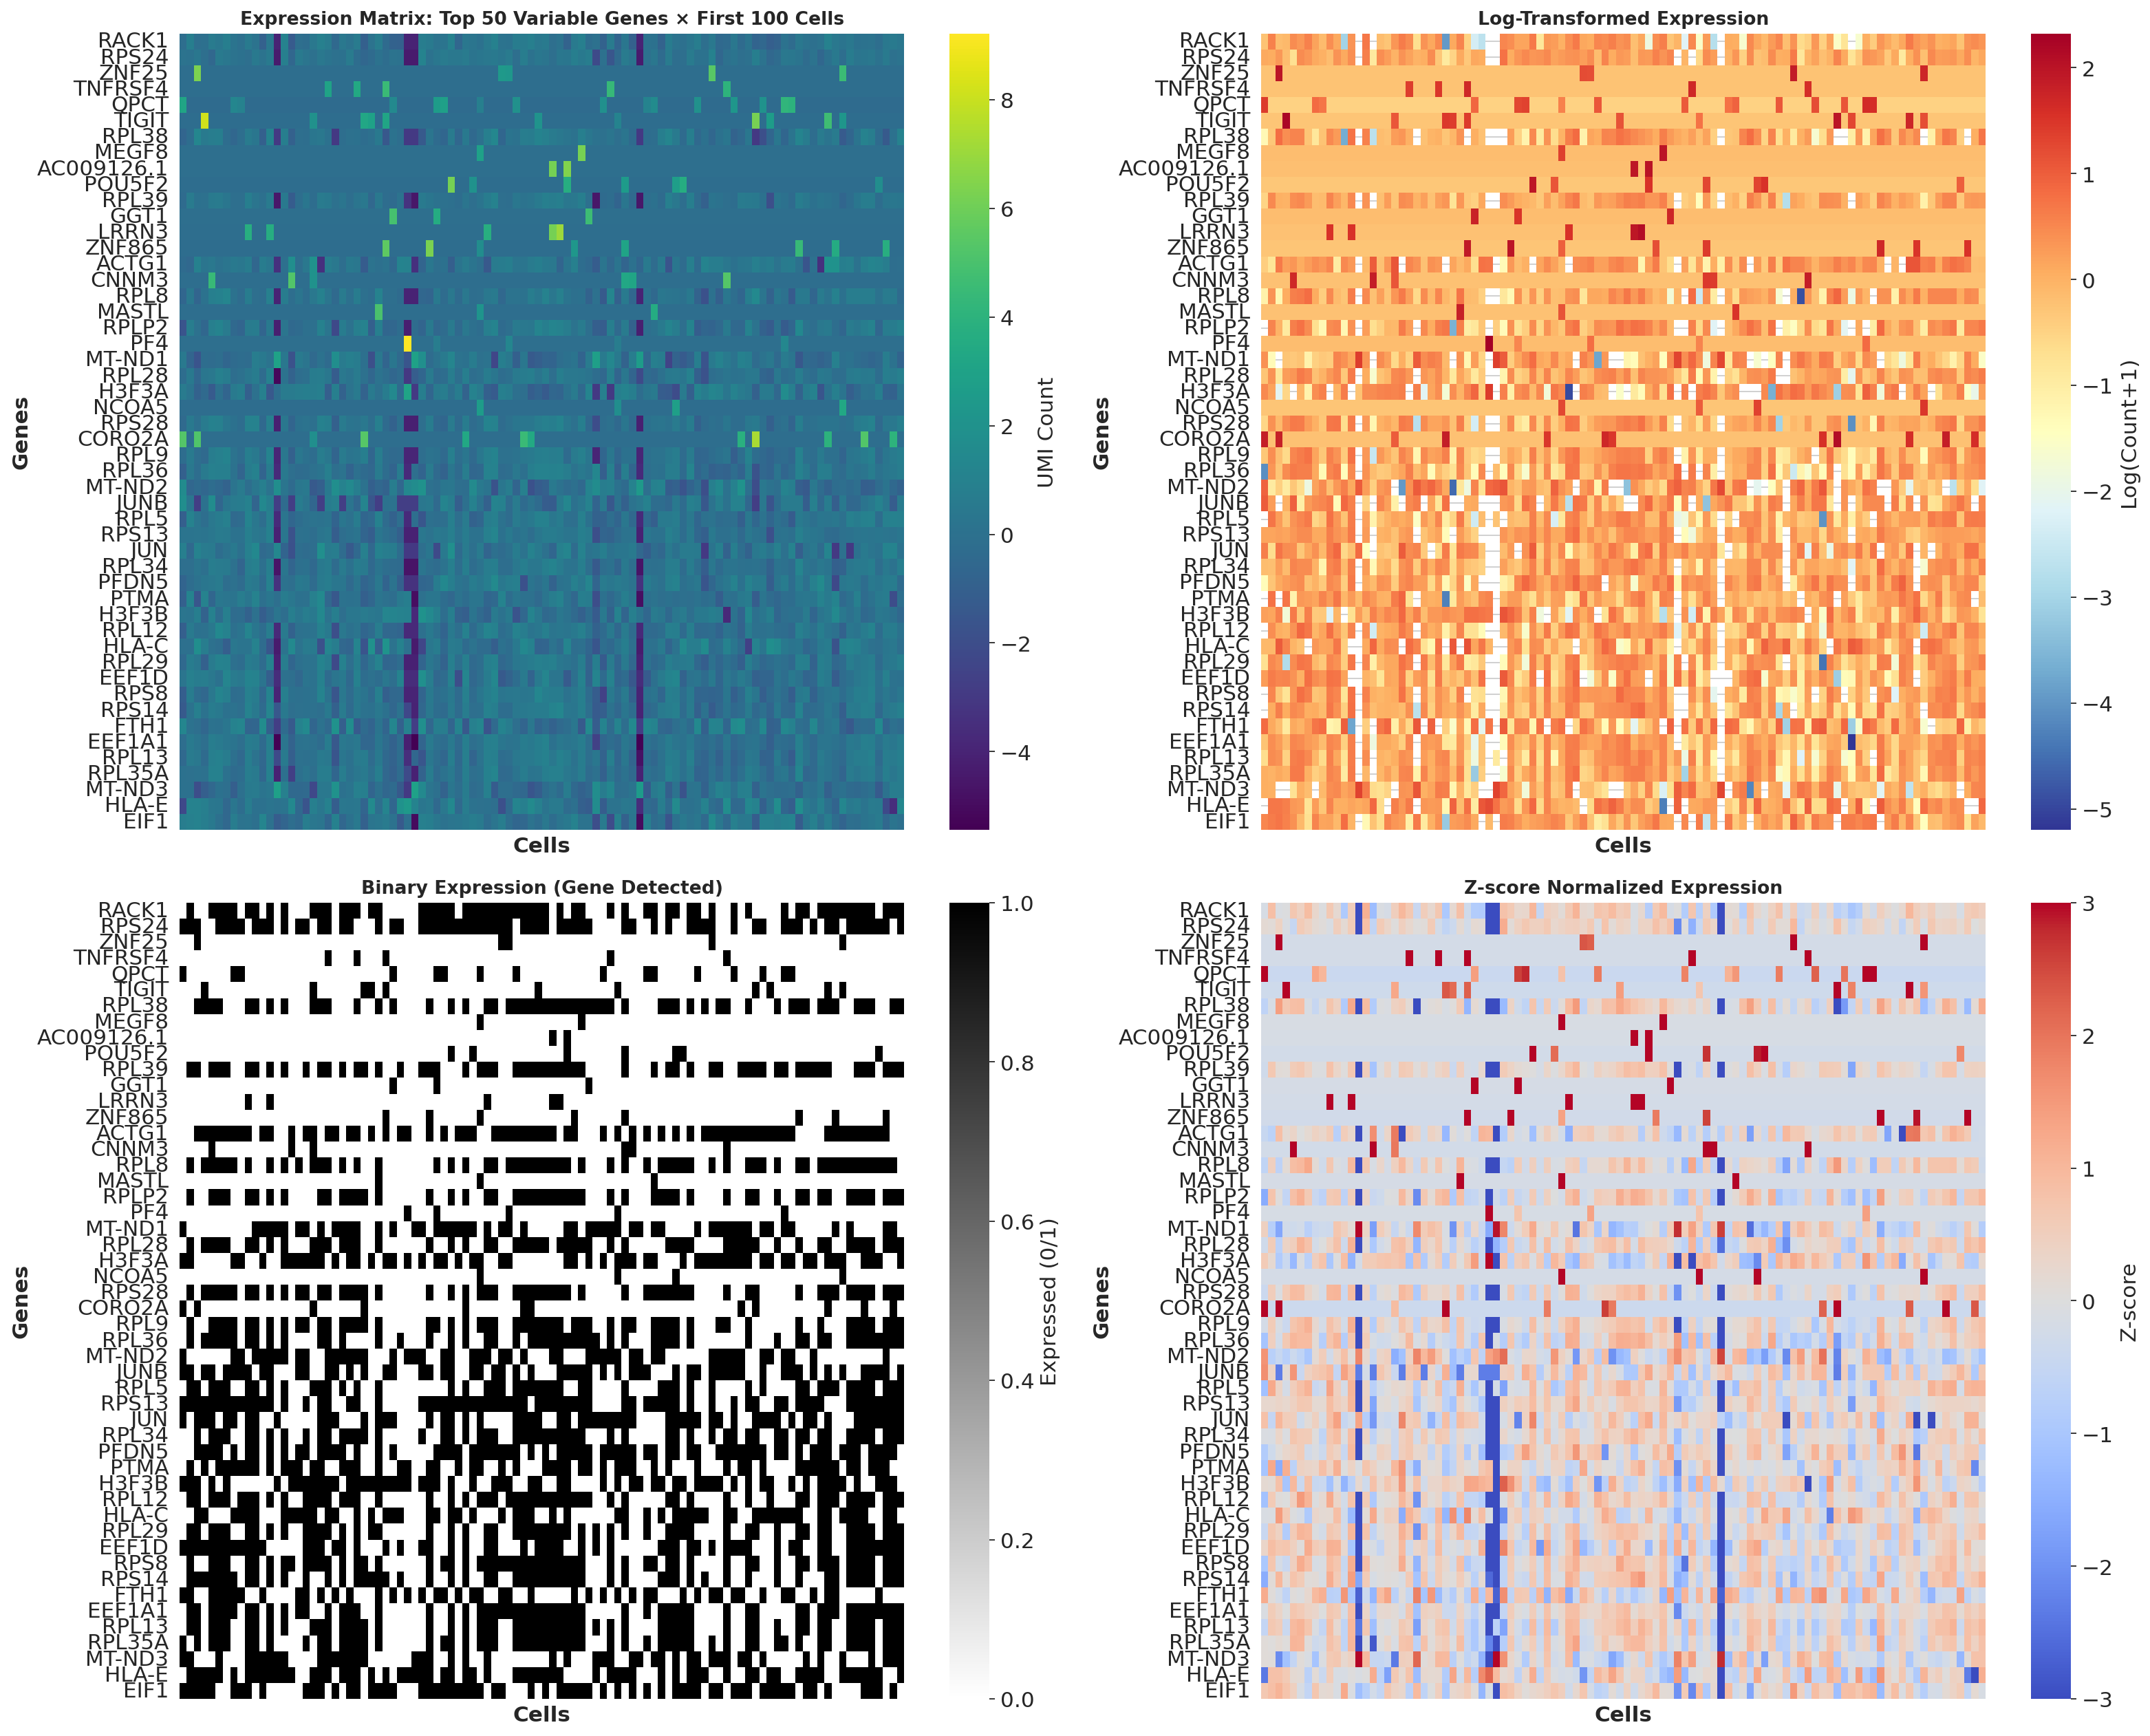


📋 Expression Matrix as DataFrame:

            RACK1     RPS24     ZNF25   TNFRSF4      QPCT     TIGIT     RPL38  \
Cell_0  -0.222679  0.124872 -0.221438 -0.214764  3.187759 -0.248646 -0.719607   
Cell_1   0.753998  0.066047 -0.221438 -0.214764 -0.376342 -0.248646 -0.265279   
Cell_2  -0.149967  0.372551  6.348347 -0.214764 -0.376342 -0.248646  1.262160   
Cell_3  -0.102532 -0.141182 -0.221438 -0.214764 -0.376342  8.171560  0.556112   
Cell_4   0.596144 -0.515510 -0.221438 -0.214764 -0.376342 -0.248646  0.726469   
...           ...       ...       ...       ...       ...       ...       ...   
Cell_95  0.166934  0.405513 -0.221438 -0.214764 -0.376342 -0.248646  0.709867   
Cell_96 -0.216231  0.110371 -0.221438 -0.214764 -0.376342 -0.248646 -0.361916   
Cell_97  0.454257  0.554331 -0.221438 -0.214764 -0.376342 -0.248646 -1.355282   
Cell_98  0.561887 -0.040436 -0.221438 -0.214764 -0.376342 -0.248646  0.043792   
Cell_99  0.393143  0.139631 -0.221438 -0.214764 -0.376342 -0.248646  1.08

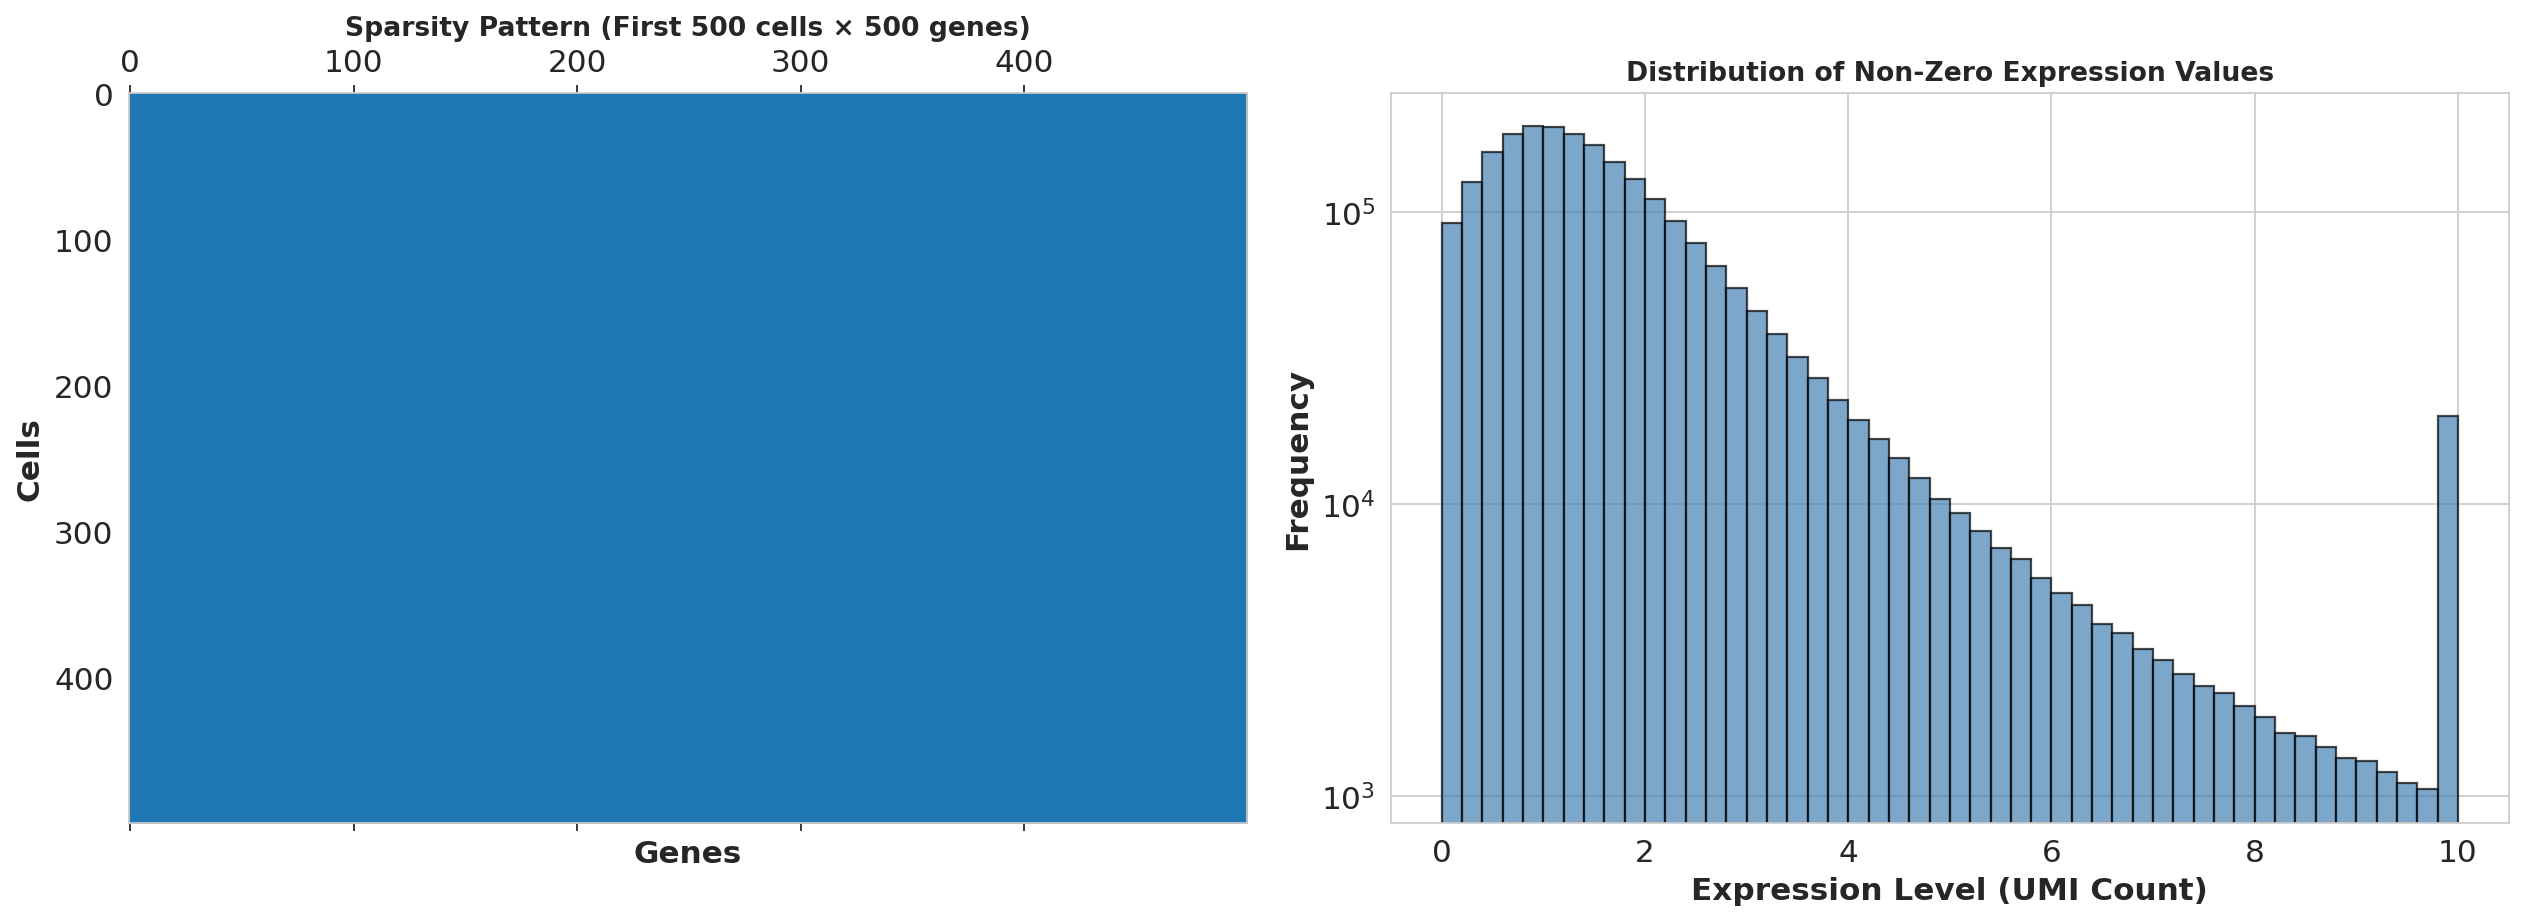


📊 EXPRESSION MATRIX SUMMARY
Matrix shape: 1,176 cells × 15,246 genes
Total values: 17,929,296
Non-zero values: 17,929,296 (100.00%)
Zero values: 0 (0.00%)

Expression statistics:
  Min: -10.0
  Max: 10.0
  Mean: -0.00
  Median: -0.18
  Mean (non-zero): 1.82

📋 First 20 cells × 20 genes:
------------------------------------------------------------
         AL627309.1  AL669831.5  LINC00115    FAM41C     NOC2L    KLHL17   PLEKHN1  AL645608.8      HES4     ISG15      AGRN  C1orf159  LINC01342  TNFRSF18   TNFRSF4      SDF4   B3GALT6  C1QTNF12    UBE2J2  LINC01786
Cell_0    -0.070173   -0.243399  -0.174195 -0.164028 -0.536009 -0.135363 -0.061368   -0.093772 -0.204318 -0.649536 -0.088071   -0.1605  -0.049949 -0.180146 -0.214764 -0.590551 -0.330425 -0.079091 -0.552204  -0.062477
Cell_1    -0.070173   -0.243399  -0.174195 -0.164028 -0.536009 -0.135363 -0.061368   -0.093772 -0.204318  1.187944 -0.088071   -0.1605  -0.049949 -0.180146 -0.214764 -0.590551 -0.330425 -0.079091 -0.552204  -0.062477

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print(f"📊 Dataset: {adata.n_obs} cells × {adata.n_vars} genes\n")

# =============================================================================
# Option 1: View RAW expression matrix (sparse, most values are 0)
# =============================================================================

print("🔍 Raw Expression Matrix:")
print(f"   Shape: {adata.X.shape}")
print(f"   Type: {type(adata.X)}")
print(f"   Data:\n")

# Convert sparse to dense (if sparse)
if hasattr(adata.X, 'toarray'):
    expression_matrix = adata.X.toarray()
else:
    expression_matrix = adata.X

print(expression_matrix)
print(f"\n   Min: {expression_matrix.min()}")
print(f"   Max: {expression_matrix.max()}")
print(f"   Mean: {expression_matrix.mean():.2f}")
print(f"   Non-zero values: {np.count_nonzero(expression_matrix):,} / {expression_matrix.size:,}")

# =============================================================================
# Option 2: Heatmap of TOP genes and cells
# =============================================================================

print("\n📊 Creating heatmap visualizations...\n")

# Select top 50 most variable genes and first 100 cells
n_genes_show = 50
n_cells_show = 100

# Get top variable genes
gene_var = expression_matrix.var(axis=0)
top_gene_indices = np.argsort(gene_var)[-n_genes_show:]
top_genes = adata.var_names[top_gene_indices]

# Subset data
subset_matrix = expression_matrix[:n_cells_show, top_gene_indices]

# Create heatmap
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Heatmap 1: Raw counts
sns.heatmap(subset_matrix.T,
            cmap='viridis',
            xticklabels=False,
            yticklabels=top_genes if n_genes_show <= 50 else False,
            cbar_kws={'label': 'UMI Count'},
            ax=axes[0, 0])
axes[0, 0].set_xlabel('Cells', fontweight='bold')
axes[0, 0].set_ylabel('Genes', fontweight='bold')
axes[0, 0].set_title(f'Expression Matrix: Top {n_genes_show} Variable Genes × First {n_cells_show} Cells',
                      fontsize=12, fontweight='bold')

# Heatmap 2: Log-transformed
log_matrix = np.log1p(subset_matrix)
sns.heatmap(log_matrix.T,
            cmap='RdYlBu_r',
            xticklabels=False,
            yticklabels=top_genes if n_genes_show <= 50 else False,
            cbar_kws={'label': 'Log(Count+1)'},
            ax=axes[0, 1])
axes[0, 1].set_xlabel('Cells', fontweight='bold')
axes[0, 1].set_ylabel('Genes', fontweight='bold')
axes[0, 1].set_title('Log-Transformed Expression', fontsize=12, fontweight='bold')

# Heatmap 3: Binary (expressed or not)
binary_matrix = (subset_matrix > 0).astype(int)
sns.heatmap(binary_matrix.T,
            cmap='binary',
            xticklabels=False,
            yticklabels=top_genes if n_genes_show <= 50 else False,
            cbar_kws={'label': 'Expressed (0/1)'},
            ax=axes[1, 0])
axes[1, 0].set_xlabel('Cells', fontweight='bold')
axes[1, 0].set_ylabel('Genes', fontweight='bold')
axes[1, 0].set_title('Binary Expression (Gene Detected)', fontsize=12, fontweight='bold')

# Heatmap 4: Z-score normalized
from scipy.stats import zscore
z_matrix = zscore(subset_matrix, axis=0)
sns.heatmap(z_matrix.T,
            cmap='coolwarm',
            center=0,
            xticklabels=False,
            yticklabels=top_genes if n_genes_show <= 50 else False,
            cbar_kws={'label': 'Z-score'},
            vmin=-3, vmax=3,
            ax=axes[1, 1])
axes[1, 1].set_xlabel('Cells', fontweight='bold')
axes[1, 1].set_ylabel('Genes', fontweight='bold')
axes[1, 1].set_title('Z-score Normalized Expression', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# =============================================================================
# Option 3: Full matrix as pandas DataFrame
# =============================================================================

print("\n📋 Expression Matrix as DataFrame:\n")

import pandas as pd

# Create DataFrame (using subset for display)
df_expression = pd.DataFrame(
    subset_matrix,
    index=[f'Cell_{i}' for i in range(n_cells_show)],
    columns=top_genes
)

print(df_expression)
print(f"\nShape: {df_expression.shape}")

# =============================================================================
# Option 4: Show sparsity pattern
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Sparsity pattern (black = expressed, white = zero)
axes[0].spy(expression_matrix[:500, :500], markersize=0.5, aspect='auto')
axes[0].set_xlabel('Genes', fontweight='bold')
axes[0].set_ylabel('Cells', fontweight='bold')
axes[0].set_title('Sparsity Pattern (First 500 cells × 500 genes)',
                  fontsize=12, fontweight='bold')

# Distribution of expression values
non_zero_values = expression_matrix[expression_matrix > 0]
axes[1].hist(non_zero_values, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Expression Level (UMI Count)', fontweight='bold')
axes[1].set_ylabel('Frequency', fontweight='bold')
axes[1].set_title('Distribution of Non-Zero Expression Values', fontsize=12, fontweight='bold')
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

# =============================================================================
# Summary Statistics
# =============================================================================

print("\n" + "="*60)
print("📊 EXPRESSION MATRIX SUMMARY")
print("="*60)
print(f"Matrix shape: {expression_matrix.shape[0]:,} cells × {expression_matrix.shape[1]:,} genes")
print(f"Total values: {expression_matrix.size:,}")
print(f"Non-zero values: {np.count_nonzero(expression_matrix):,} ({np.count_nonzero(expression_matrix)/expression_matrix.size*100:.2f}%)")
print(f"Zero values: {expression_matrix.size - np.count_nonzero(expression_matrix):,} ({(1 - np.count_nonzero(expression_matrix)/expression_matrix.size)*100:.2f}%)")
print(f"\nExpression statistics:")
print(f"  Min: {expression_matrix.min()}")
print(f"  Max: {expression_matrix.max()}")
print(f"  Mean: {expression_matrix.mean():.2f}")
print(f"  Median: {np.median(expression_matrix):.2f}")
print(f"  Mean (non-zero): {non_zero_values.mean():.2f}")
print("="*60)

# =============================================================================
# Option 5: Interactive table view (first 20x20)
# =============================================================================

print("\n📋 First 20 cells × 20 genes:")
print("-" * 60)

# Create a nice formatted display
display_matrix = expression_matrix[:20, :20]
display_df = pd.DataFrame(
    display_matrix,
    index=[f'Cell_{i}' for i in range(20)],
    columns=[f'{adata.var_names[i]}' for i in range(20)]
)

# Format for better display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 10)

print(display_df.to_string())

---

# Part 5: Imaging Data

## 5.1: Access Human Protein Atlas Images

## 5.2: Download Sample Pathology Images

## 5.3: Access TCGA Imaging Data

---

# Summary


### 1. Reference Genomes ✅
- Download chromosomes from NCBI
- Get gene sequences by name
- Access Ensembl reference data

### 2. Genomics Data ✅
- Search NCBI databases
- Download variant data from dbSNP
- Access GenBank sequences

### 3. Transcriptomics Data ✅
- Search GEO database
- Download RNA-seq datasets
- Access single-cell data

### 4. Imaging Data ✅
- Access Human Protein Atlas
- Download pathology images
- Query TCGA imaging repository

---

## Key Resources

### Genomics
- **NCBI**: https://www.ncbi.nlm.nih.gov/
  - GenBank, RefSeq, dbSNP, ClinVar
- **Ensembl**: https://www.ensembl.org/
  - Genome annotations, variation data
- **UCSC Genome Browser**: https://genome.ucsc.edu/
  - Reference genomes, genome tracks
- **1000 Genomes**: https://www.internationalgenome.org/
  - Human genetic variation

### Transcriptomics
- **GEO (Gene Expression Omnibus)**: https://www.ncbi.nlm.nih.gov/geo/
  - Microarray and RNA-seq data
- **SRA (Sequence Read Archive)**: https://www.ncbi.nlm.nih.gov/sra
  - Raw sequencing data
- **GTEx**: https://gtexportal.org/
  - Tissue-specific gene expression
- **TCGA**: https://portal.gdc.cancer.gov/
  - Cancer genomics data
- **10x Genomics**: https://www.10xgenomics.com/resources/datasets
  - Single-cell datasets

### Imaging
- **Human Protein Atlas**: https://www.proteinatlas.org/
  - Protein expression images
- **TCGA Imaging**: https://portal.gdc.cancer.gov/
  - Cancer pathology slides
- **IDC (Imaging Data Commons)**: https://imaging.datacommons.cancer.gov/
  - Cancer imaging data
- **OpenSlide Test Data**: https://openslide.cs.cmu.edu/download/openslide-testdata/
  - Sample whole slide images

---

## Best Practices

### 1. **Always Set Your Email for NCBI** ⚠️
```python
Entrez.email = "your.email@example.com"
```
NCBI **requires** this for API usage!

### 2. **Check File Sizes Before Downloading**
- **Chromosomes**: 50-250 MB each
- **Whole genomes**: 3+ GB
- **Single-cell datasets**: 10-100+ MB
- **Whole slide images**: 100 MB - 10+ GB

### 3. **Use Appropriate Data Versions**
- **GRCh38/hg38**: Current human genome (2013+)
- **GRCh37/hg19**: Previous version (2009)
- Always check which version a dataset uses!

### 4. **Cache Downloaded Data**
```python
if os.path.exists(filename):
    print(f"File exists: {filename}")
    return filename  # Don't re-download
```

### 5. **Respect Rate Limits**
- **NCBI**: Max 3 requests/second without API key
- **NCBI with API key**: 10 requests/second
- Add delays between requests if needed:
```python
import time
time.sleep(0.34)  # ~3 requests/second
```

### 6. **Handle Errors Gracefully**
```python
try:
    data = download_data()
except Exception as e:
    print(f"Error: {e}")
    # Have a backup plan
```

### 7. **Cite Data Sources**
Always acknowledge data sources in publications!

**Example citations:**
- NCBI: "Data from NCBI GenBank (https://www.ncbi.nlm.nih.gov/)"
- GEO: "Data from GEO Series GSE##### (Barrett et al., 2013)"
- TCGA: "Data from TCGA Research Network (https://www.cancer.gov/tcga)"

---

## Common Data Formats

### Genomics
| Format | Description | Use Case |
|--------|-------------|----------|
| FASTA | Sequence data | Reference genomes, gene sequences |
| FASTQ | Sequencing reads + quality | Raw sequencing data |
| VCF | Variant calls | SNPs, indels, structural variants |
| BED | Genomic regions | Gene annotations, ChIP-seq peaks |
| BAM | Aligned reads | Mapped sequencing data |

### Transcriptomics
| Format | Description | Use Case |
|--------|-------------|----------|
| CSV/TSV | Count matrices | Gene expression tables |
| H5AD | AnnData format | Single-cell data (scanpy) |
| MTX | Market Matrix | Sparse single-cell counts |
| H5 | HDF5 format | 10x Genomics data |

### Imaging
| Format | Description | Use Case |
|--------|-------------|----------|
| SVS | Aperio format | Whole slide images |
| TIFF | Standard image | Microscopy images |
| JPEG/PNG | Compressed | Web display, thumbnails |
| DICOM | Medical imaging | Clinical scans (MRI, CT) |

---

## Exercises

### Genomics (Exercises 1-4):
1. **Download BRCA2 gene sequence**
   - Use `get_gene_sequence('BRCA2')`
   - Calculate its length and GC content

2. **Get chromosome 21 sequence**
   - Download a 1 Mb region: positions 10,000,000 to 11,000,000
   - Count the number of 'N' bases (unknown)

3. **Search variants in TP53**
   - Find 10 variants in the TP53 gene
   - Print their rs IDs

4. **Compare chromosome sizes**
   - Look up the sizes of chr X and chr Y
   - Calculate the size difference

### Transcriptomics (Exercises 5-8):
5. **Search GEO for Alzheimer's data**
   - Search: "alzheimer disease RNA-seq"
   - List the top 5 results with sample counts

6. **Load PBMC 68k dataset**
   - Use `sc.datasets.pbmc68k_reduced()`
   - Print number of cells and genes

7. **Find highly expressed genes**
   - In PBMC3k dataset, calculate mean expression
   - Find top 10 most expressed genes

8. **Compare datasets**
   - Load 3 different scanpy datasets
   - Create a table comparing their sizes

### Imaging (Exercises 9-10):
9. **Find protein expression images**
   - Search Human Protein Atlas for TP53
   - Find images for liver tissue

10. **Download tissue images**
    - Download H&E images for 3 different tissues
    - Display them in a grid

---

## Troubleshooting

### Problem: NCBI download fails
**Solution**:
- Check your email is set: `Entrez.email = "your@email.com"`
- Check internet connection
- Try again later (server may be busy)

### Problem: File too large
**Solution**:
- Download smaller regions first
- Use streaming downloads
- Check available disk space

### Problem: GEO download slow
**Solution**:
- Be patient (some datasets are large)
- Use `destdir` parameter to save to specific location
- Consider downloading during off-peak hours

### Problem: Import errors
**Solution**:
```bash
pip install --upgrade biopython geoparse scanpy
```

---

## Next Steps

Now that you know how to **access** omics data, proceed to learn how to **analyze** it:

### 📓 **Notebook 1: Genomics Packages**
- Biopython, pysam, PyVCF, pybedtools
- Sequence manipulation, variant calling
- **Duration**: ~70 minutes

### 📓 **Notebook 2: Transcriptomics Packages**
- pandas, scanpy, anndata, gseapy
- Bulk RNA-seq and single-cell analysis
- **Duration**: ~70 minutes

### 📓 **Notebook 3: Imagomics Packages**
- PIL, scikit-image, opencv, squidpy
- Image processing, spatial transcriptomics
- **Duration**: ~30 minutes

---

## 🎓 Congratulations!

**You now know how to access public omics data!**

### Key skills acquired:
- ✅ Download human reference genome sequences
- ✅ Access NCBI databases (GenBank, dbSNP)
- ✅ Query and download GEO datasets
- ✅ Get single-cell RNA-seq data
- ✅ Find and access imaging resources

### Remember:
- 🔑 Always set your email for NCBI
- 💾 Cache downloaded data
- ⏱️ Respect rate limits
- 📚 Cite data sources

**Happy analyzing! 🧬📊🔬**